In [2]:
#加载必要的库
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms  #torchvison.datasets提供很多公开数据集

ImportError: cannot import name 'COMMON_SAFE_ASCII_CHARACTERS' from 'charset_normalizer.constant' (d:\Anaconda\envs\py3.8\lib\site-packages\charset_normalizer\constant.py)

In [57]:
#定义超参数  认为定义的参数
BATCH_SIZE = 128 #每批处理的数据
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #选择训练的设备是GPU还是CPU。
EPOCHS = 5  #训练的轮次

In [58]:
## 构建网络模型
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 10, 5) #1:灰度图片输入通道  10：输出通道(卷积核的个数)  5：kernel卷积核大小 （卷积层）
        self.conv2 = nn.Conv2d(10, 20, 3)#10：输入通道 20：输出通道 3：kernel （卷积层）
        self.fc1 = nn.Linear(20*10*10, 500)#20*10*10：输入通道 500：输出通道 全连接层
        self.fc2 = nn.Linear(500, 10)#500：输入通道 10：输出通道 全连接层 (线性层) 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,ceil_mode=False)
        self.relu = nn.ReLU() #inplace 是否覆盖input
    
    def forward(self,x):  #前向传播过程
        input_size = x.size(0) #batch_size

        x = self.conv1(x) #输入：batch_size*1*28*28 输出：batch_size*10*24*24 (24 = 28 - 5 + 1) （卷积层）
        x = F.relu(x)  #激活函数，在所有隐藏层之间增加激活函数提高表达能力

        #x = F.max_pool2d(x, 2, 2) #（池化层），对图片进行压缩，输入：bantch*10*24*24 输出：batch*10*12*12  取池化核中最大的值
        x = self.maxpool1(x)
        
        x = self.conv2(x) #输入：batch*10*12*12 输出batch*20*10*10 （10 = 12 - 3 + 1）
        x = F.relu(x)

        x = x.view(input_size, -1) #拉平，-1自动计算维度，20*10*10=2000
        #或者x = torch.flatten(x, 1)

        x = self.fc1(x) #输入：batch*2000 输出：batch*500
        x = F.relu(x)

        x = self.fc2(x) #输入：batch*500 输出：batch*10

        output = F.log_softmax(x,dim=1) #计算分类后，每个数字的概率值

        return output

In [59]:
## 定义训练方法
def train_model(model, device, train_loader, optimizer, epoch, loss_list, correct_list):
    #模型训练
    correct = 0.0
    train_loss = 0.0
    train_bar = tqdm(train_loader)
    model.train()
    for batch_index, (data, target) in enumerate(train_bar):  #data为一个batch
        #部署到device上
        data, target = data.to(device), target.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #训练后的结果
        output = model(data)
        pred = output.argmax(dim=1)
        correct += pred.eq(target.view_as(pred)).sum().item()
        #计算损失，多分类问题的损失（交叉熵）
        loss = F.cross_entropy(output, target).cuda()
        train_loss += loss.item()
        #反向传播（将梯度返回model，优化器利用梯度优化参数）
        loss.backward()
        #参数优化(根据模型中的梯度，进行调优)
        optimizer.step()
        train_bar.set_description(f"Epoch {epoch}:")
    train_loss /= len(train_loader.dataset)
    correct = correct/len(train_loader.dataset)*100
    loss_list.append(train_loss)
    correct_list.append(correct)

In [60]:
## 定义测试方法
def test_model(model, device, test_loader):
    #模型验证
    model.eval()
    #正确率
    correct = 0.0
    #测试损失
    test_loss = 0.0

    with torch.no_grad(): #不计算梯度，不反向传播
        for data, target in test_loader:
            #部署到device
            data, target = data.to(device), target.to(device)
            #data, target = data.cuda(), target.cuda() 数据部署到GPU

            #测试数据
            output = model(data)
            #计算损失
            test_loss += F.cross_entropy(output, target).item()
            #获取预测值
            pred = output.argmax(dim=1)
            #累计正确的个数
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    print(f"Test Average Loss:{test_loss:.4f}, Accuracy:{correct/len(test_loader.dataset)*100:.3f}")

In [61]:
## 构建pipeline，对图像做处理，transform是pytorch为转换图片提供的工具
pipeline = transforms.Compose([
    transforms.ToTensor(),  #将图片转换为tensor
    transforms.Normalize((0.1307,),(0.3081,)) #正则化降低模型复杂度，解决过拟合
])

In [62]:
## 下载，加载数据
from torch.utils.data import DataLoader

#下载数据集 
#img, target = train_set[0] 获取数据集的内容和标签
#train_set[0] 调用的是__getitem__()默认函数
#test_set.classes[target] 获取标签名称
#train_set和test_set 都是 Dataset类的实例（可以自行重写）  from torch.utils.data import Dataset 
train_set = datasets.MNIST("Data", train=True, download=True, transform=pipeline)

test_set = datasets.MNIST("Data", train=False, download=True, transform=pipeline)

'''img, target = train_set[0]
print(img.shape)
print(train_set.classes[target])'''

#加载数据 
#装载数据时确定了每个batch大小 batch_size变量
#将batch_size个img和target进行打包返回
#train_set和test_set 都是 Dataset类的实例（可以自行重写）
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) 

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

type(train_loader)


torch.utils.data.dataloader.DataLoader

In [71]:
##查看 MNIST中文件的图片
'''with open("./Data/MNIST/raw/t10k-images-idx3-ubyte","rb") as f:
    file = f.read()

image1 = [int(str(item).encode("ascii"), 16) for item in file [16 : 16+784]]
import cv2
import numpy as np
image1_np = np.array(image1, dtype=np.uint8).reshape(28,28,1)

print(image1_np.shape)
cv2.imwrite("digit.jpg", image1_np)'''

(28, 28, 1)


C:\Users\Xu\AppData\Local\Temp\ipykernel_15060\2164844242.py:8: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 389 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  image1_np = np.array(image1, dtype=np.uint8).reshape(28,28,1)
C:\Users\Xu\AppData\Local\Temp\ipykernel_15060\2164844242.py:8: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 345 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)`
will give the desired result (the cast overflows).
  image1_np = np.array(image1, dtype=np.uint8).reshape(28,28,1)
C:\Users\Xu\AppData\Local\Temp\ipykernel_15060\2164844242.py:8: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conver

True

In [64]:
 ## 定义优化器
model = Net().to(DEVICE) ##模型实例化
loss_list = []
correct_list = []
optimizer = optim.Adam(model.parameters()) ##调节模型参数的优化器

In [65]:
for epoch in range(1, EPOCHS+1):
    train_model(model, DEVICE, train_loader, optimizer, epoch, loss_list, correct_list)
    test_model(model,DEVICE,test_loader)



Epoch 1:: 100%|██████████| 469/469 [00:06<00:00, 73.95it/s]


Test Average Loss:0.0004, Accuracy:98.400


Epoch 2:: 100%|██████████| 469/469 [00:06<00:00, 75.05it/s]


Test Average Loss:0.0003, Accuracy:98.780


Epoch 3:: 100%|██████████| 469/469 [00:06<00:00, 77.86it/s]


Test Average Loss:0.0003, Accuracy:98.940


Epoch 4:: 100%|██████████| 469/469 [00:06<00:00, 76.94it/s]


Test Average Loss:0.0002, Accuracy:99.010


Epoch 5:: 100%|██████████| 469/469 [00:06<00:00, 76.53it/s]


Test Average Loss:0.0002, Accuracy:99.100


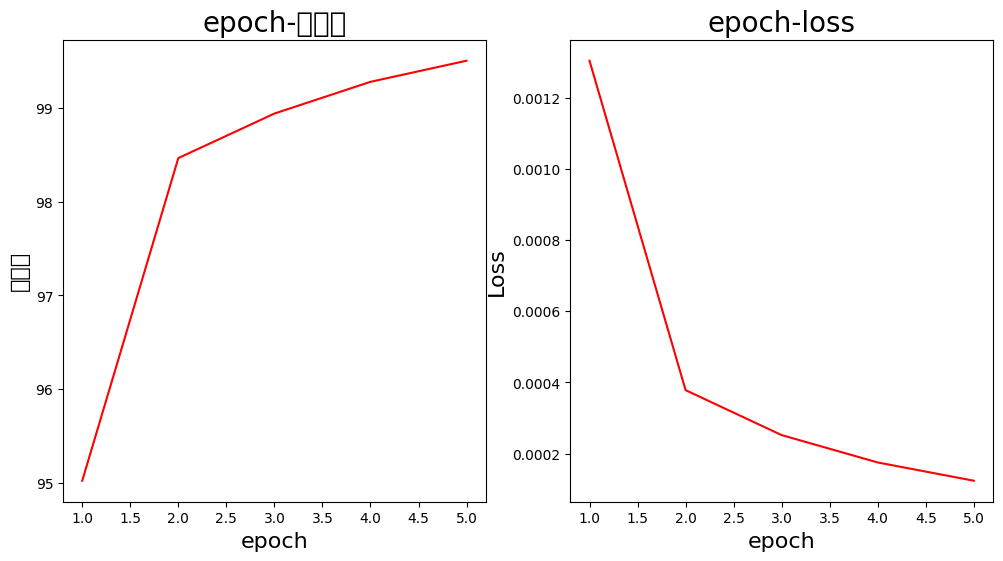

In [70]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(12, 6))
plt.subplot(121)
plt.plot(range(1, EPOCHS+1), correct_list, c='red', label="准确率")
plt.xlabel("epoch", fontdict={'size': 16})
plt.ylabel("准确率", fontdict={'size': 16})
plt.title("epoch-准确率", fontdict={'size': 20})
plt.subplot(122)
plt.plot(range(1, EPOCHS+1), loss_list, c='red', label="Loss")
plt.xlabel("epoch", fontdict={'size': 16})
plt.ylabel("Loss", fontdict={'size': 16})
plt.title("epoch-loss", fontdict={'size': 20})
plt.show()